

##  **Librerías utilizadas**

In [ ]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats


# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_blobs
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
import multiprocessing
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from google.colab import drive

from collections import Counter
from numpy.random import RandomState
from imblearn.over_sampling import SMOTE

# Configuración warnings
# ==============================================================================
#import warnings
#warnings.filterwarnings('once')

# Variables globales
semilla = 42

## **Análisis descriptivo**

### **Leer los datos del archivo**

In [ ]:

drive.mount('/content/drive')

df_base=pd.read_csv("drive/MyDrive/TFM/DataSetProd.csv")
display(df_base.head(5))

Mounted at /content/drive


,AF365,AF450,35 deg,42 deg,grupo
0,2.320158,1.229614,13.01,19.39,Control
1,1.529274,0.616514,8.18,24.78,Control
2,1.908257,0.955847,7.75,16.90,Control
3,1.590625,1.018495,4.10,16.30,Control
4,1.617071,1.242961,5.76,21.05,Control


### **Variables numéricas**

In [ ]:
datos_numericos = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_var_numericas = df_base.select_dtypes(include=datos_numericos).copy()
df_var_numericas.head(5)

,AF365,AF450,35 deg,42 deg
0,2.320158,1.229614,13.01,19.39
1,1.529274,0.616514,8.18,24.78
2,1.908257,0.955847,7.75,16.90
3,1.590625,1.018495,4.10,16.30
4,1.617071,1.242961,5.76,21.05


#### Se verifican el valor mínimo, el máximo, la mediana y la media, de las variables numéricas

In [ ]:
df_quartiles=df_var_numericas.describe()
display(df_quartiles)

,AF365,AF450,35 deg,42 deg
count,124.000000,124.000000,124.000000,124.000000
mean,2.575719,1.683305,7.269597,14.861048
std,0.814076,0.731116,2.899653,5.746477
min,0.410494,0.270591,2.100000,3.700000
25%,2.061781,1.292338,5.457500,10.552500
50%,2.550161,1.633922,6.700000,14.675000
75%,3.051504,1.942651,8.630000,18.592500
max,4.855556,6.458824,17.290000,32.480000


En este caso no se observan valores faltantes en las variables neméricas

In [ ]:
col_total_nulos = df_var_numericas.isnull().sum()
serie_col_nombres = col_total_nulos[col_total_nulos > 0]
display(serie_col_nombres)

Series([], dtype: int64)

#### Verificar valores atípicos

AF365 F1:  0.5771965720000005 F3:  4.536089135999999
AF450 F1:  0.3168678017500006 F3:  2.9181208117499997
35 deg F1:  0.6987499999999978 F3:  13.388750000000002
42 deg F1:  -1.507500000000002 F3:  30.652500000000003


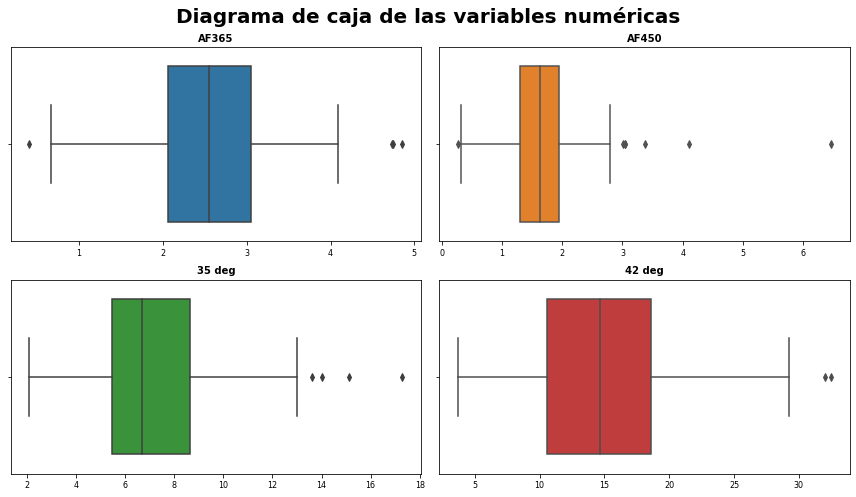

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))
axes = axes.flat

def boxplot(df):
  i=0
  for colum in df:
    sns.boxplot(
        x       = df[colum],
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        ax=axes[i])
    axes[i].set_title(colum, fontsize = 10, fontweight = "bold")
    axes[i].tick_params(labelsize = 8)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    i+=1

    # encontrar Q1, Q3 y rango intercuartílico para cada columna
    Q1 = df.quantile (q = .25)[colum]
    Q3 = df.quantile (q = .75)[colum]
    IQR = df.apply (stats.iqr)[colum]
    F1 = Q1-1.5*IQR
    F3 = Q3+1.5*IQR
    print(colum, 'F1: ', F1, 'F3: ',F3)
    
    

boxplot(df_var_numericas)
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Diagrama de caja de las variables numéricas', fontsize = 20, fontweight = "bold");



#### De acuerdo con el grafico, sobre la dispersión de los datos se observar que la variable AF450 se encuentra menos dispersas que las demás. Por otro lado, sobre los valores atípicos, de acuerdo con límite inferior f1 y límite superior f3 (calculado por el método de rango intercuartílico), si existen valores atípicos en el conjunto de datos, por lo que podrían hacer ruido en los modelos a crear.
***En este ejercicio vamos a tratar estos outliers como outliers buenos ya que en el ejercicio anterior, al aplicar el tratamiento de datos, la clase "Diabetes_c" se vio bastante afectada en el balanceo. Entonces vamos a utilizar estos datos sin aplicar alguna tecnica de tratamiento de datos.***

#### Distribución de variables númericas para verificar si existe simetría

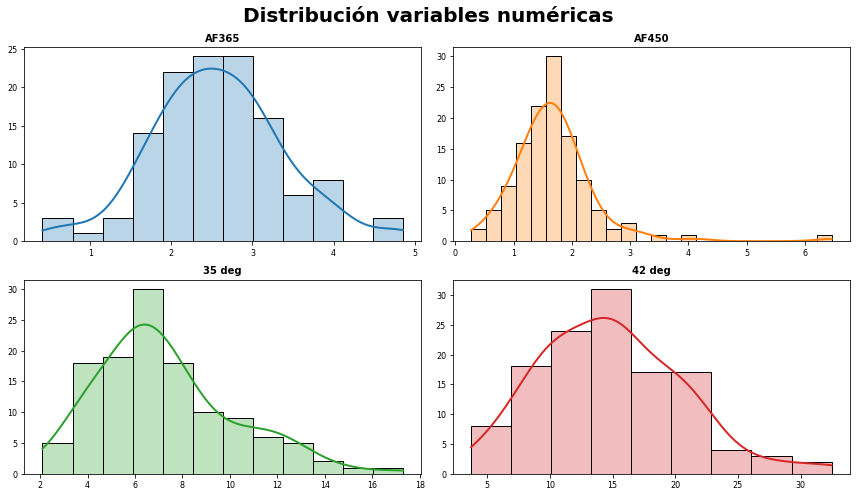

In [ ]:
def histograma(df):
  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))
  axes = axes.flat

  for i, colum in enumerate(df):
      sns.histplot(
          
          data    = df,
          x       = colum,
          stat    = "count",
          kde     = True,
          color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
          line_kws= {'linewidth': 2},
          alpha   = 0.3,
          ax      = axes[i]
      )
      axes[i].set_title(colum, fontsize = 10, fontweight = "bold")
      axes[i].tick_params(labelsize = 8)
      axes[i].set_xlabel("")
      axes[i].set_ylabel("")
      
  fig.tight_layout()
  plt.subplots_adjust(top = 0.9)
  fig.suptitle('Distribución variables numéricas', fontsize = 20, fontweight = "bold");
histograma(df_var_numericas)

### **Correlación de las variables numéricas**

In [ ]:
corr_matrix=df_var_numericas.corr()
display(corr_matrix)

,AF365,AF450,35 deg,42 deg
AF365,1.000000,0.541802,-0.180744,-0.469525
AF450,0.541802,1.000000,-0.133801,-0.412165
35 deg,-0.180744,-0.133801,1.000000,0.683498
42 deg,-0.469525,-0.412165,0.683498,1.000000


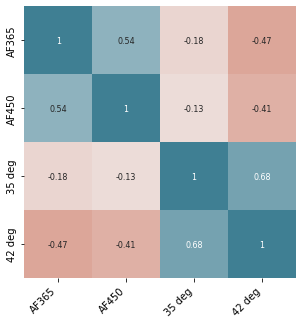

In [ ]:
# Heatmap matriz de correlaciones
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

#### Las variables de amplitud de fluorescencia se encuentra con una relación del 54% y las variables de perfusión cuenta con una relación del 68%. Tienen sentido ya que tienen la misma unidad de medida

### **Variables no numéricas**

In [ ]:

df_var_no_numericas = df_base[df_base.columns.difference(df_var_numericas.columns)].copy()
df_var_no_numericas.head(5)

,grupo
0,Control
1,Control
2,Control
3,Control
4,Control


#### Se verifican las diferentes categorías con su respectiva frecuencia , de las variables categóricas

In [ ]:
display(df_var_no_numericas.describe())
grupo=df_var_no_numericas['grupo']

,grupo
count,124
unique,3
top,Diabetes
freq,62


#### En este caso tampoco hay columnas que tengan datos faltantes

In [ ]:
total_no_numericas = df_var_no_numericas.isna().sum()
serie_col_nombres = total_no_numericas[total_no_numericas > 0]
display(serie_col_nombres)

Series([], dtype: int64)

#### Tabla de frecuencia 

In [ ]:
pd.value_counts(grupo)

Diabetes      62
Control       48
Diabetes_c    14
Name: grupo, dtype: int64

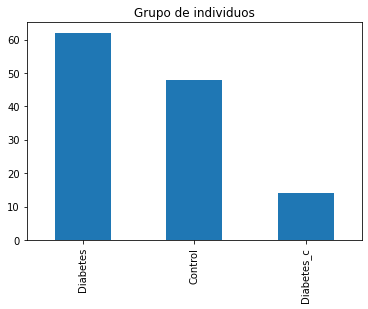

In [ ]:

plot = grupo.value_counts().plot(kind='bar',
                                            title='Grupo de individuos')

#### Tabla de frecuencia relativa

In [ ]:
100 * grupo.value_counts() / len(grupo)

Diabetes      50.000000
Control       38.709677
Diabetes_c    11.290323
Name: grupo, dtype: float64

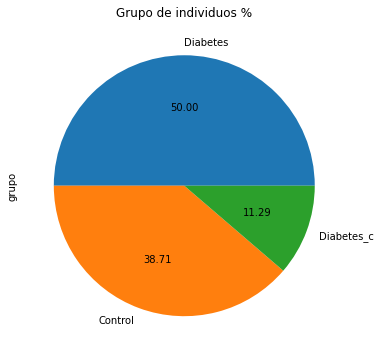

In [ ]:
plot = grupo.value_counts().plot(kind='pie', autopct='%.2f', 
                                            figsize=(6, 6),
                                            title='Grupo de individuos %')

Se observan que los datos se encuentran desbalanceados

## **Parametrización**

* Se segmenta los datos en dos conjuntos uno de entrenamiento con el 70% y de prueba 30% del total de datos respectivamente.

In [ ]:
train_x,test_x,train_y,test_y=train_test_split(df_base.drop(columns = 'grupo'),df_base['grupo'],test_size=0.3, random_state = semilla)#,stratify=df_base['grupo']
print('Dataset test shape %s' % Counter(test_y))
print(len(train_x))
print(len(train_y))

Dataset test shape Counter({'Control': 19, 'Diabetes': 15, 'Diabetes_c': 4})
86
86


### ***Funciones***

In [ ]:
def calcularGridSearchCV(estimador, parametros):
  grid = GridSearchCV(estimador, parametros,scoring="f1_weighted", n_jobs= multiprocessing.cpu_count() - 1, cv= 5)
    
  # fitting the model for grid search
  grid_search=grid.fit(train_x, train_y)
  print(grid_search.best_params_)
  print(grid_search.best_estimator_)
  predY_test=grid.predict(test_x)
  class_report=classification_report(test_y,predY_test)
  print(class_report)
  print('Accuracy Score testing: ' + str(accuracy_score(test_y,predY_test)))
  print('Accuracy Score training: ' + str(grid_search.best_score_))
  ConfusionMatrixDisplay.from_estimator(grid, test_x, test_y,cmap=plt.cm.Blues)

### ***Funciones***

## **Entrenamiento con Arbol de decisión**

Se realiza el entrenamiento con Grid Search basado en out-of-bag score, contemplando los parametros por defecto

In [ ]:

# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {
                    'criterion'   : ['gini', 'entropy'],
                    'splitter'    : ['best', 'random'],
                    'max_depth'   : [None, 5,10,15,20,50,100,150,200],
                    'min_samples_split': [2,5,10,15, 20],
                    'min_samples_leaf': [1,2,5,10,15,20],
                    'max_features': [0.25,0.5,0.6, 0.75, 1],#['auto','sqrt', 'log2'],
                    'ccp_alpha':    [0.0,0.1, 0.01, 0.001,0.0001],
                    'class_weight': ['balanced', None],
                 
                }
            )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_accuracy': []}

for params in param_grid:
  #class_weight={"Diabetes_c":3.5},
    tree_model = DecisionTreeClassifier(random_state=semilla,
                                             ** params)
    
    tree_model.fit(train_x, train_y)
    score=tree_model.score(test_x,test_y)
    resultados['params'].append(params)
    resultados['oob_accuracy'].append(score)
    #print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados.head(10)

,oob_accuracy,ccp_alpha,class_weight,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,splitter
31566,0.868421,0.0100,None,entropy,100.0,0.5,1,15,best
53486,0.868421,0.0001,None,entropy,150.0,0.5,5,15,best
42968,0.868421,0.0010,None,entropy,200.0,0.5,1,20,best
20176,0.868421,0.1000,None,entropy,20.0,0.5,2,15,best
42966,0.868421,0.0010,None,entropy,200.0,0.5,1,15,best
5762,0.868421,0.0000,None,gini,5.0,0.5,1,5,best
5760,0.868421,0.0000,None,gini,5.0,0.5,1,2,best
53488,0.868421,0.0001,None,entropy,150.0,0.5,5,20,best
49022,0.868421,0.0001,None,gini,5.0,0.6,1,5,best
49020,0.868421,0.0001,None,gini,5.0,0.6,1,2,best


              precision    recall  f1-score   support

     Control       0.94      0.79      0.86        19
    Diabetes       0.78      0.93      0.85        15
  Diabetes_c       1.00      1.00      1.00         4

    accuracy                           0.87        38
   macro avg       0.91      0.91      0.90        38
weighted avg       0.88      0.87      0.87        38

Accuracy Score : 0.868421052631579


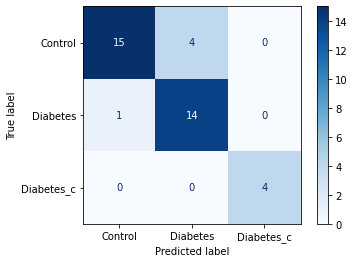

In [ ]:
tree_model = DecisionTreeClassifier(criterion='entropy',
                                    max_depth = 10,
                                    max_features=0.5,
                                    min_samples_leaf=1,
                                    min_samples_split=20,
                                    splitter='best',
                                    class_weight=None,
                                    ccp_alpha=0.1,
                                    random_state=semilla
                                    )
model=tree_model.fit(train_x,train_y)
predEY_clas_rnd=tree_model.predict(test_x)
class_report=classification_report(test_y,predEY_clas_rnd)
print(class_report)
print('Accuracy Score : ' + str(accuracy_score(test_y,predEY_clas_rnd)))
ConfusionMatrixDisplay.from_estimator(tree_model, test_x, test_y,cmap=plt.cm.Blues)

## **Entrenamiento con Random Forest**

Se realiza el entrenamiento con Grid Search basado en out-of-bag score, contemplando los parametros por defecto





In [ ]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                 {
                    'n_estimators':     [50,100,150,200],
                    'criterion'   :     ['gini', 'entropy'],
                    'max_depth'   :     [None,5,10,15,20,50],
                    'min_samples_split':[2, 5, 10,15,20],
                    'min_samples_leaf': [1,2, 5, 10,15,20],
                    'max_features': [0.25,0.5, 0.75, 1],#[None,'sqrt', 'log2'],
                    'class_weight': ['balanced', None],
                    'ccp_alpha':    [0.0,0.1, 0.01, 0.001],
                 
                }
            )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_accuracy': []}

for params in param_grid:
    
    modelo = RandomForestClassifier(
                oob_score    = True,
                n_jobs       = -1,
                random_state= semilla,
                ** params
             )
    
    modelo.fit(train_x, train_y)
    
    resultados['params'].append(params)
    resultados['oob_accuracy'].append(modelo.oob_score_)
    #print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados.head(10)

,oob_accuracy,ccp_alpha,class_weight,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators
39063,0.860465,0.001,balanced,entropy,15.0,0.50,10,2,200
28511,0.860465,0.010,balanced,entropy,50.0,0.50,10,10,200
25287,0.860465,0.010,balanced,gini,20.0,0.75,15,5,200
15078,0.860465,0.100,balanced,entropy,5.0,0.50,10,20,150
2561,0.860465,0.000,balanced,gini,50.0,0.50,5,2,100
2565,0.860465,0.000,balanced,gini,50.0,0.50,5,5,100
2569,0.860465,0.000,balanced,gini,50.0,0.50,5,10,100
2574,0.860465,0.000,balanced,gini,50.0,0.50,5,15,150
15074,0.860465,0.100,balanced,entropy,5.0,0.50,10,15,150
25283,0.860465,0.010,balanced,gini,20.0,0.75,15,2,200


array([[16,  3,  0],
       [ 3, 10,  2],
       [ 0,  0,  4]])

              precision    recall  f1-score   support

     Control       0.84      0.84      0.84        19
    Diabetes       0.77      0.67      0.71        15
  Diabetes_c       0.67      1.00      0.80         4

    accuracy                           0.79        38
   macro avg       0.76      0.84      0.79        38
weighted avg       0.79      0.79      0.79        38

Accuracy Score : 0.7894736842105263


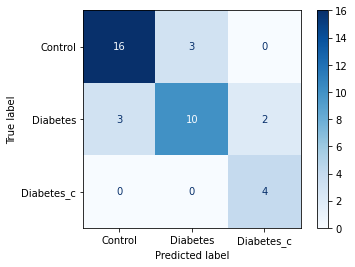

In [ ]:
new_clas_rndforest = RandomForestClassifier(n_estimators=200,n_jobs=-1,random_state=semilla,max_depth=15,max_features=0.5, criterion='entropy',min_samples_leaf=10,min_samples_split=2,class_weight='balanced',ccp_alpha=0.001)
new_clas_rndforest.fit(train_x,train_y)
predEY_clas_rnd=new_clas_rndforest.predict(test_x)
display(confusion_matrix(test_y,predEY_clas_rnd))
class_report=classification_report(test_y,predEY_clas_rnd)
print(class_report)
print('Accuracy Score : ' + str(accuracy_score(test_y,predEY_clas_rnd)))
ConfusionMatrixDisplay.from_estimator(new_clas_rndforest, test_x, test_y,cmap=plt.cm.Blues)


## **Entrenamiento con SVM**

Se realiza el entrenamiento con Grid Search CV, contemplando los parametros por defecto

{'svc__C': 1, 'svc__class_weight': None, 'svc__degree': 0, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
              precision    recall  f1-score   support

     Control       0.82      0.74      0.78        19
    Diabetes       0.60      0.80      0.69        15
  Diabetes_c       1.00      0.25      0.40         4

    accuracy                           0.71        38
   macro avg       0.81      0.60      0.62        38
weighted avg       0.75      0.71      0.70        38

Accuracy Score testing: 0.7105263157894737
Accuracy Score training: 0.8354819907761085


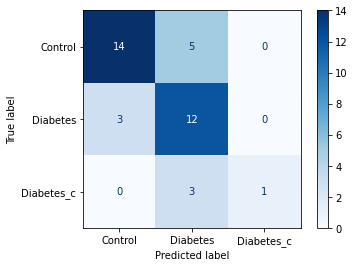

In [ ]:

new_ml = SVC(random_state =semilla) 
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('svc', new_ml)])

# defining parameter range
param_grid = {
              'svc__C': [ 0.1,1,5,10,20,30,50],
              'svc__kernel': ['linear','poly','rbf','sigmoid'], 
              'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001],#['scale', 'auto'],
              'svc__degree': [0,0.5, 1, 2, 3, 4, 5, 6],
              'svc__class_weight': ['balanced', None]
              } 
calcularGridSearchCV(pipe,param_grid)

## **Entrenamiento con Red Neuronal (Multi-layer Perceptron classifier)**

Se realiza el entrenamiento con RandomizedSearchCV, contemplando los parametros por defecto

In [ ]:
# Pipeline de preprocedado y modelado
# ==============================================================================

# Identificación de columnas numéricas y categóricas
numeric_cols = train_x.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = train_x.select_dtypes(include=['object', 'category']).columns.to_list()


# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', MLPClassifier( max_iter= 2500,random_state = semilla))])

In [ ]:
# Espacio de búsqueda de cada hiperparámetro
# ==============================================================================
param_distributions = {
    'modelo__hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'modelo__activation': ['identity','logistic','tanh','relu'],
    'modelo__solver': ['lbfgs','sgd','adam'],
    'modelo__alpha': [0.0001,0.05],
    'modelo__learning_rate': ['constant','invscaling','adaptive']
}

# Búsqueda por validación cruzada
# ==============================================================================
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 50,
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = 5,
        return_train_score = True
       )

grid_search=grid.fit(X = train_x, y = train_y)


In [ ]:
modelo_final = grid.best_estimator_

accuracy = grid_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )
y_test_hat=modelo_final.predict(test_x)
test_accuracy=accuracy_score(test_y,y_test_hat)*100
test_accuracy
print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy) )
modelo_final['modelo'].get_params()

Accuracy for our training dataset with tuning is : 82.68%
Accuracy for our testing dataset with tuning is : 73.68%


{'activation': 'identity',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 2500,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 42,
 'shuffle': True,
 'solver': 'sgd',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

              precision    recall  f1-score   support

     Control       0.82      0.74      0.78        19
    Diabetes       0.63      0.80      0.71        15
  Diabetes_c       1.00      0.50      0.67         4

    accuracy                           0.74        38
   macro avg       0.82      0.68      0.72        38
weighted avg       0.77      0.74      0.74        38

Accuracy Score testing: 0.7368421052631579


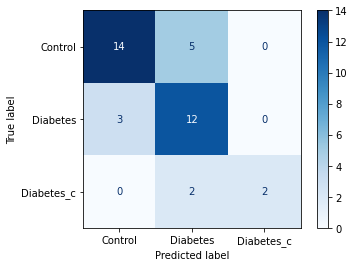

In [ ]:
confusion_matrix(test_y,y_test_hat)
#disp=plot_confusion_matrix(grid, test_x, test_y,cmap=plt.cm.Blues)
class_report=classification_report(test_y,y_test_hat)
print(class_report)
print('Accuracy Score testing: ' + str(accuracy_score(test_y,y_test_hat)))
ConfusionMatrixDisplay.from_estimator(modelo_final, test_x, test_y,cmap=plt.cm.Blues)

## **Entrenamiento con Nearest Neighbors Classification**

Se realiza el entrenamiento con Grid Search, contemplando los parametros por defecto

{'knn__algorithm': 'auto', 'knn__leaf_size': 10, 'knn__n_neighbors': 5, 'knn__p': 1, 'knn__weights': 'distance'}
              precision    recall  f1-score   support

     Control       0.86      0.63      0.73        19
    Diabetes       0.59      0.87      0.70        15
  Diabetes_c       1.00      0.50      0.67         4

    accuracy                           0.71        38
   macro avg       0.82      0.67      0.70        38
weighted avg       0.77      0.71      0.71        38

Accuracy Score testing: 0.7105263157894737
Accuracy Score training: 0.8160304727951786


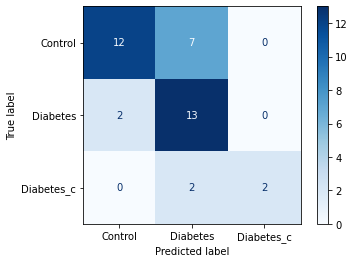

In [ ]:

knn = KNeighborsClassifier(n_jobs=-1)
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('knn', knn)])

# defining parameter range
param_grid = {
              'knn__n_neighbors': [ 5,10,20,30,50],
              'knn__weights': ['uniform','distance'], 
              'knn__algorithm': ['auto', 'ball_tree','kd_tree','brute'],
              'knn__leaf_size': [10,20,30,50],
              'knn__p': [1,2]
              } 
  
calcularGridSearchCV(pipe,param_grid)